In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("all-data.csv",sep=',', encoding='latin-1',names = ["sentiment","news"])
df

,sentiment,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [3]:
df["sentiment"].value_counts()

sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

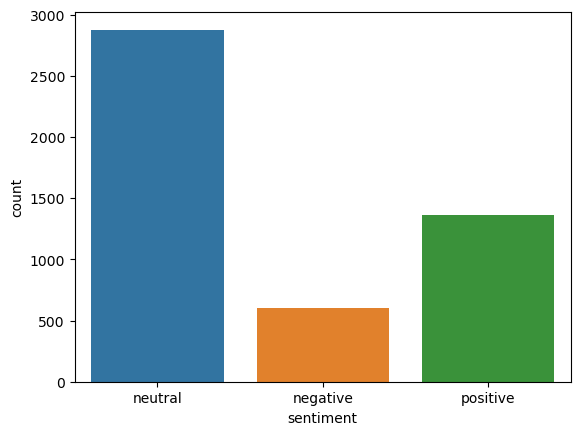

In [4]:
sns.countplot(x="sentiment",data=df)

## Exploratory Data Analysis

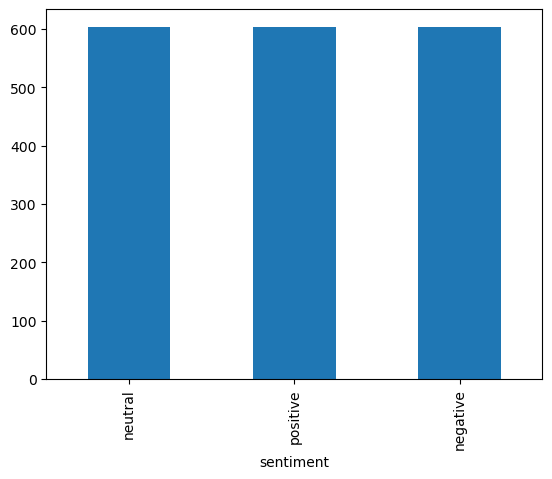

In [5]:
#Class count
count_neutral, count_positive, count_negative = df.sentiment.value_counts()

#Divide by class
df_neutral = df[df["sentiment"] == 'neutral']
df_positive = df[df["sentiment"] == 'positive']
df_negative = df[df["sentiment"] == 'negative']

df_neutral_under = df_neutral.sample(count_negative)
df_positive_under = df_positive.sample(count_negative)

df_upsampled = pd.concat([df_neutral_under, df_positive_under, df_negative], axis=0)
df_upsampled.sentiment.value_counts().plot(kind='bar');

In [6]:
df_upsampled

,sentiment,news
396,neutral,Efore 's CEO Reijo Maihaniemi said that the co...
3190,neutral,The company has decided to stop the operations...
2590,neutral,"The business area has operations in Finland , ..."
4222,neutral,Neste Oil s refineries have a combined crude o...
1803,neutral,Any investment or investment activity to which...
...,...,...
4840,negative,HELSINKI Thomson Financial - Shares in Cargote...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [7]:
# Separate the three classes
df_positive = df_upsampled[df_upsampled['sentiment'] == 'positive']
df_negative = df_upsampled[df_upsampled['sentiment'] == 'negative']
df_neutral = df_upsampled[df_upsampled['sentiment'] == 'neutral']

# Considering 80% of the data for training and 20% for testing
train_size = int(0.8 * min(len(df_positive), len(df_negative), len(df_neutral)))

# Splitting the data into training and testing sets
positive_data_points_train = df_positive.iloc[:train_size]
negative_data_points_train = df_negative.iloc[:train_size]
neutral_data_points_train = df_neutral.iloc[:train_size]

positive_data_points_test = df_positive.iloc[train_size:]
negative_data_points_test = df_negative.iloc[train_size:]
neutral_data_points_test = df_neutral.iloc[train_size:]

# Concatenate the training and test data for each class
X_train = pd.concat([positive_data_points_train["news"], negative_data_points_train["news"], neutral_data_points_train["news"]])
y_train = pd.concat([positive_data_points_train["sentiment"], negative_data_points_train["sentiment"], neutral_data_points_train["sentiment"]])

X_test = pd.concat([positive_data_points_test["news"], negative_data_points_test["news"], neutral_data_points_test["news"]])
y_test = pd.concat([positive_data_points_test["sentiment"], negative_data_points_test["sentiment"], neutral_data_points_test["sentiment"]])


## Pre-processing and Data Cleaning

In [8]:
def clean_news(news):
    '''
    Input:
        news: a string containing a news article.
    Output:
        news_cleaned: a processed news article. 
    '''
    temp = []
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Remove links
    news = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|''(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', news)

    # Remove HTML code
    news = re.sub('<.*?>', '', news)

    # Remove special characters, numbers, and convert to lowercase
    news = re.sub(r'[^a-zA-Z\s]', '', news).lower()

    # Tokenization
    tokens = word_tokenize(news)

    # Remove stopwords, apply lemmatization, and then apply Porter stemming
    tokens_cleaned = [ps.stem(lemmatizer.lemmatize(token)) for token in tokens if token not in stopwords.words('english')]

    news_cleaned = ' '.join(tokens_cleaned)

    return news_cleaned

In [9]:
def find_occurrence(frequency, word, label):
    '''
    Parameters:
    - frequency: a dictionary containing the frequencies of each pair (or tuple).
    - word: the word you want to find.
    - label: the label associated with the word.
    Returns:
    - n: the count of occurrences where the specified word, along with its corresponding label, appears.
    '''
    n = 0
    if (word,label) in frequency:
        n = frequency[(word,label)]
    return n

In [10]:
# Define the mapping from sentiment strings to integers
output_map = {'positive': 0, 'negative': 1, 'neutral': 2}

# Use the mapping to replace sentiment labels with integers in y_train and y_test
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)


In [11]:
X_train.iloc[0]

"Suominen Corporation estimates that the cost-cutting program that started in autumn 2005 , higher sales prices , and expected growth in volume of Wet Wipes , will make the company 's operations more profitable ."

In [12]:
news_ = X_train.iloc[0]

# print cleaned review
print(clean_news(news_))

suominen corpor estim costcut program start autumn higher sale price expect growth volum wet wipe make compani oper profit


In [13]:
def news_counter(output_occurrence, news, positive_neutral_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, news in zip(positive_neutral_negative, news):
        split_news = clean_news(news).split()
        for word in split_news:
            key = (word, label)
            if key not in output_occurrence:
                output_occurrence[key] = 0
            output_occurrence[key] += 1
    return output_occurrence

In [14]:
# Build the freqs dictionary for later uses
freqs = news_counter({}, X_train, y_train)

In [15]:
print(freqs)

{('suominen', 0): 3, ('corpor', 0): 20, ('estim', 0): 10, ('costcut', 0): 2, ('program', 0): 2, ('start', 0): 5, ('autumn', 0): 3, ('higher', 0): 6, ('sale', 0): 71, ('price', 0): 13, ('expect', 0): 24, ('growth', 0): 14, ('volum', 0): 5, ('wet', 0): 2, ('wipe', 0): 1, ('make', 0): 8, ('compani', 0): 94, ('oper', 0): 84, ('profit', 0): 77, ('finnish', 0): 61, ('ponss', 0): 3, ('sign', 0): 18, ('agreement', 0): 19, ('babcock', 0): 1, ('africa', 0): 6, ('distribut', 0): 4, ('support', 0): 6, ('forest', 0): 4, ('machin', 0): 7, ('harvest', 0): 2, ('head', 0): 5, ('inform', 0): 3, ('system', 0): 19, ('south', 0): 6, ('group', 0): 35, ('anticip', 0): 3, ('gain', 0): 5, ('eurm', 0): 12, ('tax', 0): 5, ('expens', 0): 1, ('loss', 0): 35, ('amount', 0): 3, ('eur', 0): 230, ('mn', 0): 111, ('compar', 0): 26, ('major', 0): 4, ('breweri', 0): 4, ('increas', 0): 56, ('domest', 0): 4, ('beer', 0): 4, ('per', 0): 19, ('cent', 0): 4, ('last', 0): 16, ('year', 0): 57, ('million', 0): 60, ('litr', 0): 2

## Naive Bayes Classifier for Building the model

In [16]:
def train_naive_bayes(freqs, train_news, train_sentiments):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_news: a list of news articles
        train_sentiments: a list of sentiment labels corresponding to the news articles (0 for positive, 1 for neutral, 2 for negative)
    Output:
        logprior: the log prior.
        loglikelihood: the log likelihood.
    '''
    loglikelihood = {}
    logprior = [0, 0, 0]  # Initialize logprior for each sentiment class

    # Calculate V, the number of unique words in the vocabulary
    vocab = set()
    for (vocab_val, label) in freqs.keys():
        vocab.add(vocab_val)
    V = len(vocab)

    # Initialize counts for each sentiment class
    num_docs = [0, 0, 0]
    num_words = [0, 0, 0]

    # Calculate the total number of documents and words for each sentiment class
    for label in train_sentiments:
        num_docs[label] += 1
    for (word, label) in freqs.keys():
        num_words[label] += freqs[(word, label)]

    # Calculate logprior for each sentiment class
    for label in range(3):  # 0 for positive, 1 for neutral, 2 for negative
        logprior[label] = np.log(num_docs[label] / len(train_news))

    # For each word in the vocabulary...
    for word in vocab:
        # Calculate word probabilities for each sentiment class
        p_word_given_sentiment = [0, 0, 0]
        for label in range(3):
            freq = find_occurrence(freqs, word, label)
            p_word_given_sentiment[label] = (1 + freq) / (V + num_words[label])

        # Calculate the log likelihood for each sentiment class
        loglikelihood[word] = [np.log(p_word_given_sentiment[label] / p_word_given_sentiment[0]) for label in range(3)]

    return logprior, loglikelihood


In [17]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
# keeping preprocessing <=0 probabliy is rounded to 0
print(len(loglikelihood))

[-1.0986122886681098, -1.0986122886681098, -1.0986122886681098]
3548


In [18]:
def naive_bayes_predict(news, logprior, loglikelihood):
    '''
    Params:
        news: a string containing a news article
        logprior: a list of logpriors for each sentiment class (positive, neutral, negative)
        loglikelihood: a dictionary of words mapping to lists of loglikelihoods for each sentiment class
    Return:
        sentiment: the predicted sentiment class (0 for positive, 1 for neutral, 2 for negative)
    '''
    
    # Process the news article to get a list of words
    word_l = clean_news(news).split()

    # Initialize probabilities for each sentiment class
    probabilities = [0, 0, 0]

    # Add the logprior for each sentiment class
    for label in range(3):  # 0 for positive, 1 for neutral, 2 for negative
        probabilities[label] += logprior[label]

    # Calculate probabilities for each sentiment class
    for word in word_l:
        # Check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # Add the log likelihood of that word to the probabilities for each sentiment class
            for label in range(3):  # 0 for positive, 1 for neutral, 2 for negative
                probabilities[label] += loglikelihood[word][label]

    # Determine the sentiment class with the highest probability
    sentiment = probabilities.index(max(probabilities))

    return sentiment


In [19]:
from sklearn.metrics import confusion_matrix

def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of news articles
        test_y: the corresponding labels for the news articles (0 for positive, 1 for neutral, 2 for negative)
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of news articles classified correctly) / (total # of news articles)
    """
    accuracy = 0  
    
    y_hats = []
    for article in test_x:
        # Predict sentiment using naive_bayes_predict function
        sentiment = naive_bayes_predict(article, logprior, loglikelihood)
        
        # Classify the sentiment into 0 (positive), 1 (neutral), or 2 (negative)
        if sentiment == 0:
            y_hat_i = 0
        elif sentiment == 1:
            y_hat_i = 1
        else:
            y_hat_i = 2

        # Append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # Calculate the accuracy based on the predicted labels
    accuracy = np.mean(np.array(y_hats) == test_y)

    # Print the confusion matrix and accuracy
    print(confusion_matrix(test_y, y_hats))
    print(accuracy)
    
    return accuracy


In [20]:
stock_market_news = [
    "Stocks Surge to New All-Time Highs Amid Positive Earnings Reports",
    "Tech Giants Apple and Amazon Announce Strong Q3 Results",
    "Market Volatility Continues as Investors Await Federal Reserve Meeting",
    "Tesla's Electric Vehicle Sales Soar, But Supply Chain Challenges Loom",
    "Oil Prices Spike as OPEC+ Fails to Reach Production Agreement",
    "Stock Market Plummets as Economic Uncertainty Rises. Investor confidence took a hit today as the stock market experienced a significant decline. Concerns over rising inflation, supply chain disruptions, and global economic uncertainty have led to a bearish trend in the market.",
    "Market Analysts Assess Impact of Recent Policy Changes. Market analysts are closely monitoring the effects of recent policy changes on stock prices. While some experts believe the changes may have a neutral impact, others are cautiously optimistic about potential positive outcomes for certain sectors."
]

for news in stock_market_news:
    sentiment = naive_bayes_predict(news, logprior, loglikelihood)
    print(f'News Article: {news} -> Predicted Sentiment: {sentiment}')


News Article: Stocks Surge to New All-Time Highs Amid Positive Earnings Reports -> Predicted Sentiment: 0
News Article: Tech Giants Apple and Amazon Announce Strong Q3 Results -> Predicted Sentiment: 1
News Article: Market Volatility Continues as Investors Await Federal Reserve Meeting -> Predicted Sentiment: 1
News Article: Tesla's Electric Vehicle Sales Soar, But Supply Chain Challenges Loom -> Predicted Sentiment: 0
News Article: Oil Prices Spike as OPEC+ Fails to Reach Production Agreement -> Predicted Sentiment: 0
News Article: Stock Market Plummets as Economic Uncertainty Rises. Investor confidence took a hit today as the stock market experienced a significant decline. Concerns over rising inflation, supply chain disruptions, and global economic uncertainty have led to a bearish trend in the market. -> Predicted Sentiment: 0
News Article: Market Analysts Assess Impact of Recent Policy Changes. Market analysts are closely monitoring the effects of recent policy changes on stock pr

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

X_train, X_test, Y_train, Y_test = train_test_split(df_upsampled['news'], df_upsampled['sentiment'], test_size=0.2)

output_map = {'positive': 0, 'negative': 1,"neutral":2}
y_train = Y_train.map(output_map)
y_test = Y_test.map(output_map)
freqs = news_counter({}, X_train, y_train)

logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

[-1.1111124514323412, -1.1027616722149212, -1.0821848145261619]
3481


In [22]:
from sklearn.metrics import confusion_matrix
# 3. printing out the confusion matrix for the train set
print("Confusion matrix for training set:")
acc1 = test_naive_bayes(X_train, y_train, logprior, loglikelihood)

Confusion matrix for training set:
[[371  92  14]
 [  8 469   4]
 [ 16  42 433]]
0.8785369220151829


In [23]:
# 3. printing out the confusion matrix for the test set
print("Confusion matrix for test set:")
acc2 = test_naive_bayes(X_test, y_test, logprior, loglikelihood)

Confusion matrix for test set:
[[62 38 27]
 [ 9 98 16]
 [22 16 75]]
0.6473829201101928


In [24]:
import pickle
# Save the model to a pickle file
with open('sentimentmodel.pkl', 'wb') as file:
    pickle.dump((logprior, loglikelihood), file)